In [2]:
import os
import sys
import seaborn as sns
import networkx as nx
import pandas as pd

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

from data.CitationsLoader import CitationsLoader

### Load dataset

In [33]:
cl =  CitationsLoader(name="pubmed", download=True)
G, Adj, n_nodes, data = cl.G, cl.Adj, cl.n_nodes, cl.data

### Really quick summary of the graph

In [29]:
print(G)

Graph with 3327 nodes and 4552 edges


In [30]:
n_nodes

3327

In [31]:
Adj.shape

torch.Size([3327, 3327])

### Plot adjacency matrix

<Axes: >

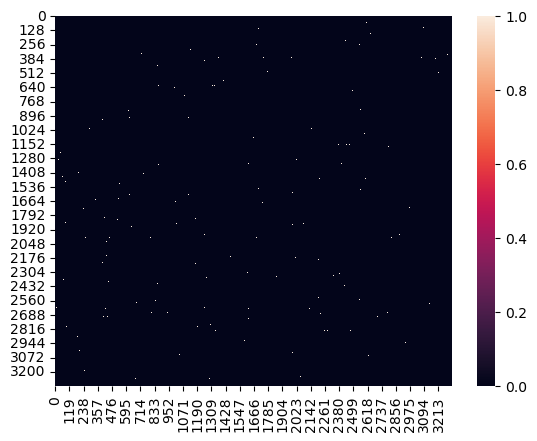

In [32]:
sns.heatmap(Adj)

### Plot node features (unique words for each publication)

In [11]:
data.x.shape # 2708 scientific publications and 1433 unique words

torch.Size([2708, 1433])

<Axes: >

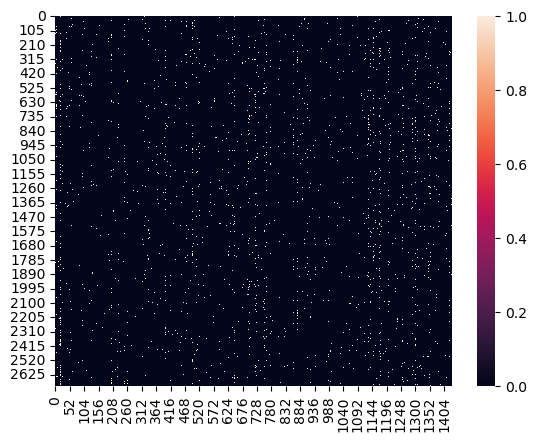

In [12]:
sns.heatmap(data.x)

### Plot graph

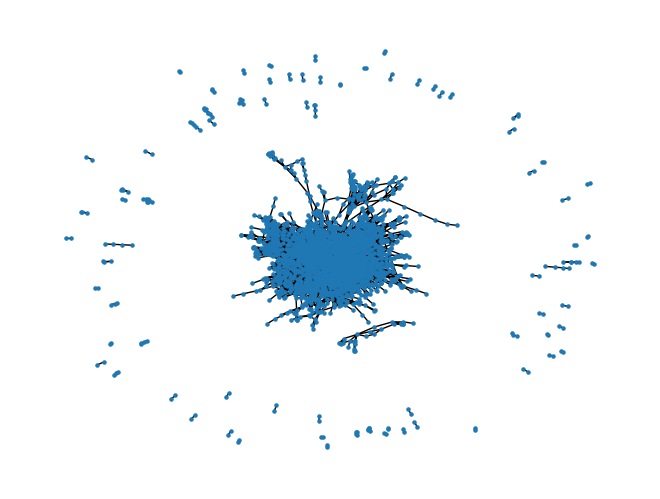

In [13]:
nx.draw(G, node_size=5)

### Check number of components (subgraphs)

In [14]:
# check there are at least two subgraphs
print("There are at least two subsgraphs") if not nx.is_connected(G) else print("There is only one subgraph")

There are at least two subsgraphs


In [15]:
# check the number of subgraphs
subgraphs = nx.connected_components(G)

print(f"Number of components (subgraphs) in G is {len([i for i in subgraphs])}")

Number of components (subgraphs) in G is 78


In [16]:
# check largest subgraph
subgraphs = nx.connected_components(G)
largest_subgraph_nodes = max(subgraphs, key=len)

print(f"Number of nodes in largest subgraph is {len(largest_subgraph_nodes)}")

Number of nodes in largest subgraph is 2485


In [17]:
largest_subgraph = G.subgraph(largest_subgraph_nodes)
diameter = nx.diameter(largest_subgraph)

print("Network diameter of largest component:", diameter)

Network diameter of largest component: 19


### Compute number of edges per node (degree of the node)

In [18]:
degrees = nx.degree(G)
degree_df = pd.DataFrame(degrees, columns=["node", "degree"]).sort_values(by="degree", ascending=False)
degree_df.head(10)

,node,degree
1358,1358,168
306,306,78
1701,1701,74
1986,1986,65
1810,1810,44
1623,1623,42
2034,2034,40
88,88,36
1013,1013,34
598,598,33


<Axes: title={'center': 'Degree distribution: mean=3.90, median=3.00'}, ylabel='Frequency'>

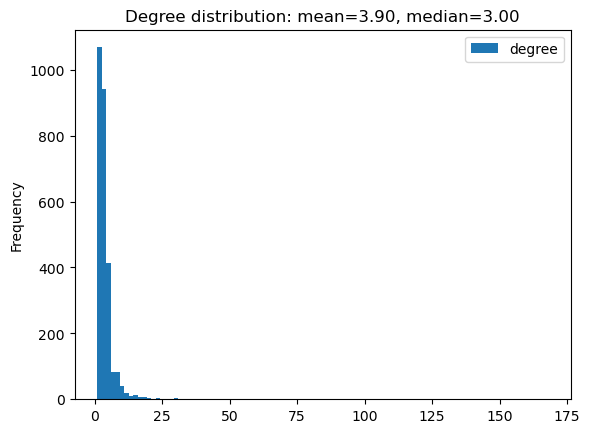

In [19]:
mean = degree_df['degree'].mean()
median = degree_df['degree'].median()

degree_df[['degree']].plot(kind='hist', bins=100, title="Degree distribution: mean={:.2f}, median={:.2f}".format(mean, median))

### Compute graph density

The graph density is simply the ratio of actual edges in the network to all possible edges in the network. It gives you a quick sense of how closely knit your network is. This also gives us a measure of sparsity.

In [20]:
density = nx.density(G)

density * 100

0.14399999126942079

### Compute shortest path

A shortest path measurement is related to the shortest possible series of nodes and edges that stand between any two nodes, something hard to see in large network visualizations. This measure is essentially finding friends-of-friends.

It is key to note that finding all the shortest paths from every path of nodes in a graph without weights is a NP hard problem. In truth, this is also a problem for weighted graphs with equal weights across edges. 

In both cases, unless we fix a pair of nodes,we can only rely on approximations. 

In [21]:
edges_node_fixed_df = pd.DataFrame(G.edges(1358), columns=["from", "to"])
edges_node_fixed_df["path"] = [len(nx.shortest_path(G, source=row['from'], target=row['from']))
                                for idx, row in edges_node_fixed_df.iterrows()]

In [22]:
edges_node_fixed_df.sort_values(["path"], ascending=False).head(5)

,from,to,path
0,1358,30,1
115,1358,1715,1
107,1358,1646,1
108,1358,1708,1
109,1358,1709,1


In [23]:
edges_node_fixed_df.sort_values(["path"], ascending=False).tail(5)

,from,to,path
57,1358,882,1
58,1358,902,1
59,1358,919,1
60,1358,929,1
167,1358,2597,1


In [24]:
subset_degree_df = degree_df.reset_index(drop=True).loc[0:10, :]

shortest_paths = []
for f in subset_degree_df["node"]:
    for t in subset_degree_df["node"]:
        if f != t:
            shortest_paths.append({"from": f, "to": t, "path": len(nx.shortest_path(G, source=f, target=t))})
shortest_paths_df = pd.DataFrame(shortest_paths)

In [25]:
shortest_paths_df.sort_values(["path"], ascending=False).head(5)

,from,to,path
46,1810,88,5
26,1701,88,5
58,1623,598,5
56,1623,88,5
78,88,598,5


In [26]:
shortest_paths_df.sort_values(["path"], ascending=False).tail(5)

,from,to,path
109,2045,598,3
19,306,2045,2
101,2045,306,2
89,1013,2045,2
108,2045,1013,2


### Compute graph diameter (from a list of shortest paths)

There are many network metrics derived from shortest path lengths. One such measure is diameter, which is the longest of all shortest paths. 

In [27]:
nx.diameter(G)

NetworkXError: Found infinite path length because the graph is not connected